In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    Scale(0.9),
    InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    Scale(0.9),
    InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

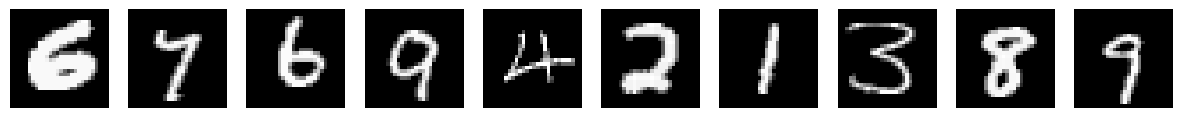

Max value:  tensor(2.9444, device='cuda:0')
Min value:  tensor(-2.9444, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [44]:
all_stats = {}

In [45]:
def train(
        model,
        train_dataset,
        val_dataset,
        BATCH_SIZE,
        NUM_EPOCHS,
        optimiser,
        scheduler,
        stats,
        norm_grads=False,
        neg_cnst=None,
        cd=None,
        eval_every=100,
):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    pos_states = [model.init_state(images.flatten(1), F.one_hot(labels, 10)) for images, labels in train_loader]
    neg_states = [model.init_state(images.flatten(1), F.one_hot(labels, 10)) for images, labels in train_loader]

    model.train()
    gamma = torch.ones(pos_states[0][0]['x'].shape[0], device=device) * model.gamma
    cd_gamma = torch.ones(pos_states[0][0]['x'].shape[0], device=device) * model.gamma

    loop = tqdm(range(NUM_EPOCHS), leave=False)
    for epoch in loop:

        if stats['epoch'] > 0:
            postfix = {'steps': stats['epoch'], 'posVFE': stats['posVfe'][-1], 'valAcc': stats['valAcc'][-1], 'valVFE': stats['valVfe'][-1]}
            if neg_cnst:
                postfix['negVFE'] = stats['negVfe'][-1]
                postfix['negMSE'] = stats['negMse'][-1]
            if cd:
                postfix['cdVFE'] = stats['cdVfe'][-1]
            loop.set_postfix(postfix)
        
        epoch_stats = {'posVfe': [], 'negVfe': [], 'cdVfe': [], 'negMse': []}
        
        for i in range(len(train_loader)):

            # Update particles and calculate new VFE
            model.step(pos_states[i], gamma, pin_obs=True, pin_target=True)
            pos_vfe = model.vfe(pos_states[i], normalise=norm_grads)
            loss = pos_vfe.clone()

            # Same For Negative particles
            if neg_cnst:
                neg_states[i][-1]['x'] = pos_states[i][-1]['x']
                # for _ in range(20):
                model.step(neg_states[i], gamma, pin_target=True)
                neg_vfe = model.vfe(neg_states[i], normalise=norm_grads)
                reconstruction = neg_states[i][0]['x']
                neg_mse = F.mse_loss(reconstruction, pos_states[i][0]['x'])
                loss -= neg_cnst*neg_vfe
            if cd:
                cd_state = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_states[i]]
                # for _ in range(cd):
                #     model.step(cd_state, cd_gamma, pin_obs=False)
                
                out, _ = model.reconstruct(cd_state[0]['x'], steps=cd)
                cd_state[0]['x'] = out

                cd_vfe = model.vfe(cd_state, normalise=norm_grads)
                loss += -0.75 * cd_vfe

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if model.has_top:
                model.top.weight.data = model.top.weight.data - torch.diag(model.top.weight.data.diag())

            # if norm_grads, recalculate VFE WITHOUT normalisation for plotting (otherwise it will be constant)
            if norm_grads:
                pos_vfe = model.vfe(pos_states[i], normalise=False)
                if neg_cnst:
                    neg_vfe = model.vfe(neg_states[i], normalise=False)
                if cd:
                    cd_vfe = model.vfe(cd_state, normalise=False)

            epoch_stats['posVfe'].append(pos_vfe.item())
            if neg_cnst:
                epoch_stats['negVfe'].append(neg_vfe.item())
                epoch_stats['negMse'].append(neg_mse.item())
            if cd:
                epoch_stats['cdVfe'].append(cd_vfe.item())
            
        if epoch % eval_every == 0:
            val_stats = val_pass(model, None, val_loader)
            stats['valAcc'].append(val_stats['acc'].item())
            stats['valVfe'].append(val_stats['vfe'].item())

        pos_vfe = sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe'])
        if pos_vfe < 0:
            raise ValueError(f'epoch VFE is negative: {pos_vfe}')
        stats['posVfe'].append(sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe']))
        if neg_cnst:
            stats['negVfe'].append(sum(epoch_stats['negVfe']) / len(epoch_stats['negVfe'])) 
            stats['negMse'].append(sum(epoch_stats['negMse']) / len(epoch_stats['negMse']))
        if cd:
            stats['cdVfe'].append(sum(epoch_stats['cdVfe']) / len(epoch_stats['cdVfe']))

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['posVfe'][-1])
        
        stats['epoch'] += 1

In [57]:
torch.manual_seed(seed)

model = FCPCN(
    sizes=[10, 600, 600, 784],
    precisions=[1.0, 1.0, 1.0, 1.0],
    bias=True, 
    symmetric=True, 
    actv_fn=F.sigmoid,
    # actv_fn=shrinkage,
    steps=20,
    gamma=0.1,
    x_decay=0.0,
    inverted = True,
).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'negMse': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}
optimiser = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-6)

In [58]:
BATCH_SIZE = 20
NUM_EPOCHS = 10000
stats = train(
    model,
    train_dataset,
    val_dataset,
    BATCH_SIZE,
    NUM_EPOCHS,
    optimiser,
    # scheduler,
    None,
    stats,
    eval_every=1,
)

 10%|▉         | 954/10000 [4:36:49<39:41:51, 15.80s/it, steps=954, posVFE=533, valAcc=0.107, valVFE=5.9]  

In [39]:
all_stats['basic'] = stats

In [40]:
for k, v in all_stats.items():
    plt.plot(v['trainVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valVfe'], label=k)
plt.legend()
plt.title('valVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valAcc'], label=k)
plt.legend()
plt.title('ValAcc')
# plt.yscale('log')
plt.show()

TypeError: 'NoneType' object is not subscriptable